# **Fault Detection of Electrofans' Bearings Using Vibration Data**
Authors: <br/>
Ali Kohan <br/>
Mohsen Salari <br/>
This notebooke is organized in following order:
+ Load dataset
+ Check feature repetition
+ Check correlation
+ Check data imbalanace and calculate baseline accuracy
+ Remove outliers
+ Visualizing pairwise relationships between features
+ Normalization
+ Exaustive search for feature selection
+ Keep selected features
+ Hyperparameter tuning using grid search
+ PCA
+ Final model
+ Confusion Matrix

## Load dataset

In [226]:
import pandas as pd

file_path = 'bearing-failure.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())


   COMP_NAME  Vel, Rms (RMS)  Acc, Rms (RMS)  Crest (RMS)  Kurt (RMS)  \
0         45          2.6210        0.565402       2.7712     -0.4659   
1         44          1.6172        0.497132       3.0444     -0.3892   
2         50          1.8830        0.220973       3.0139     -0.3220   
3         49          2.7642        0.325514       2.5970     -0.9511   
4         52          1.5803        0.936732       3.0173     -0.3647   

   Vel, Peak (RMS)  Vel, Peak to peak (RMS)  MP_LOC  Label  
0           7.8390                14.788000       0      2  
1           5.2302                10.317700       0      0  
2           5.4759                10.556100       0      0  
3           8.2149                16.053499       0      0  
4           4.9009                 9.711500       0      2  


## check feature repetition

In [181]:
df['MP_LOC'].value_counts()

16    174
12    135
14    135
13    133
15    131
18    116
17     89
1      61
2      54
5      46
6      46
7      46
11     41
21     38
4      35
22     28
19     26
0      23
8      22
20      5
Name: MP_LOC, dtype: int64

In [182]:
df['COMP_NAME'].value_counts()

79    86
24    64
81    50
39    39
66    37
      ..
22     4
23     4
28     4
64     3
85     2
Name: COMP_NAME, Length: 96, dtype: int64

## Check correlation

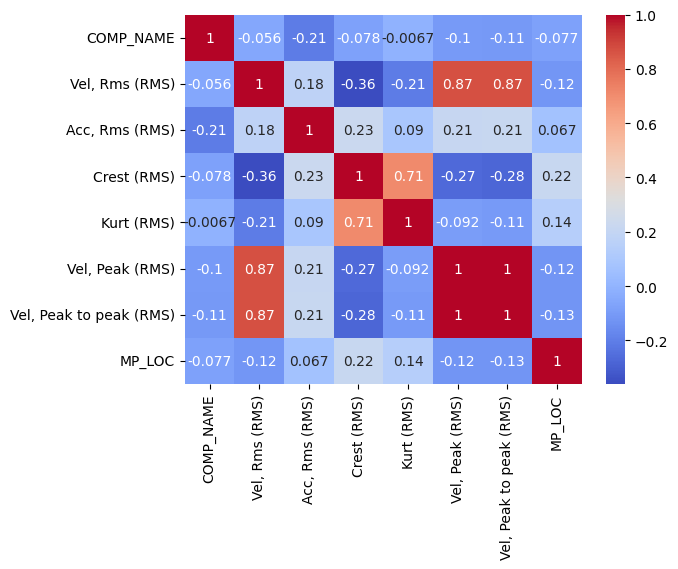

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.drop(columns=['Label']).corr()  # Exclude target column
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


## Check data imbalanace and calculate baseline accuracy

In [184]:
print(df['Label'].value_counts()/sum(df['Label'].value_counts()))

1    0.383671
0    0.369220
2    0.247110
Name: Label, dtype: float64


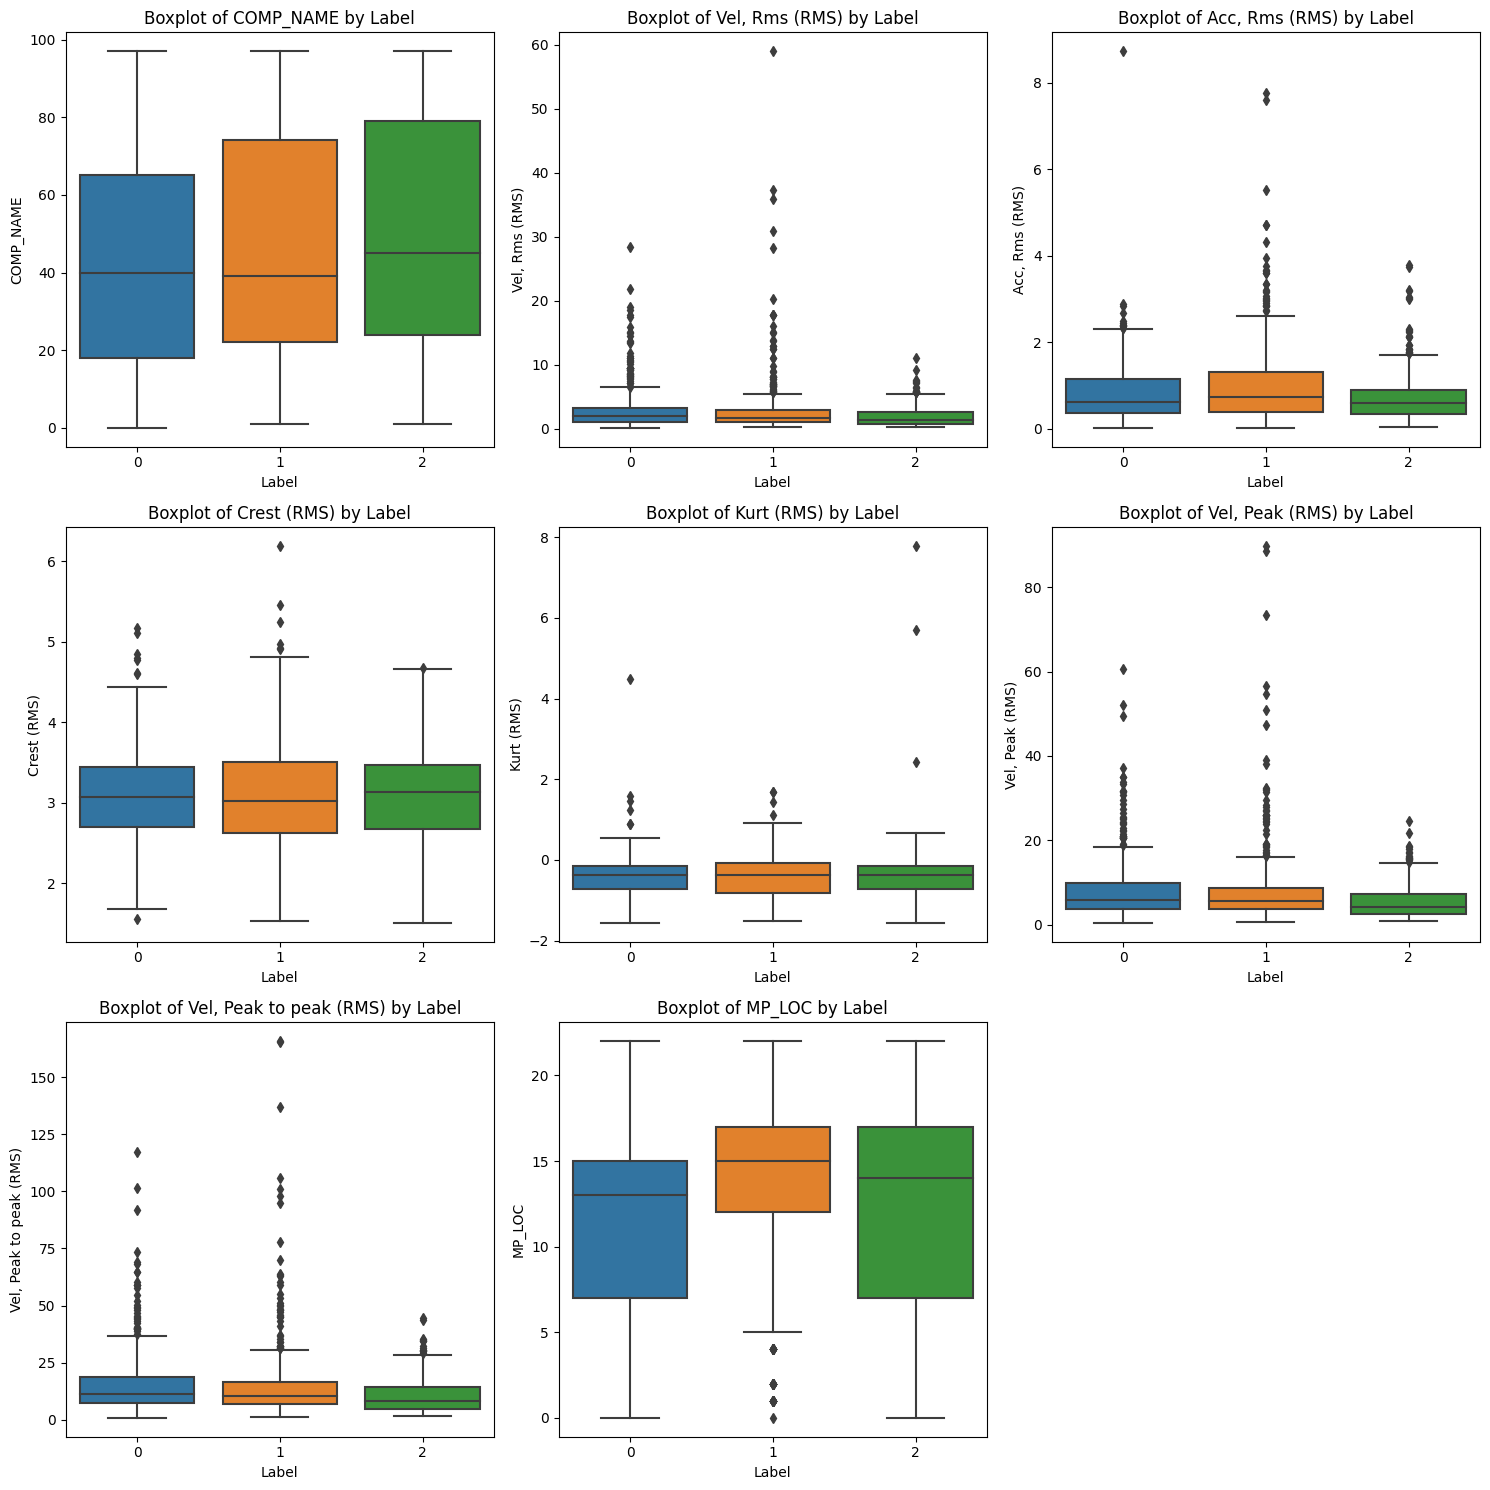

In [185]:
num_features = len(df.columns) - 1  # Exclude 'Label' column

# Define the number of rows and columns for the grid
n_cols = 3  # Set the number of columns
n_rows = (num_features + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten() # Flatten the axes for easy iteration

# Loop through each feature and plot the boxplots
for idx, column in enumerate(df.columns):
    if column != 'Label':  # Skip the 'Label' column
        sns.boxplot(x='Label', y=column, data=df, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column} by Label')  # Set a title for each subplot

# Remove empty subplots (if any)
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Remove outliers

In [186]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1                   # Interquartile range

    # Define the bounds for non-outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to keep only rows within the bounds
    print(column, ':')
    print(df.shape, '-> ', end='')
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(df_no_outliers.shape)
    return df_no_outliers


In [187]:
print('Before removing outliers:', df.shape)
columns = ['Vel, Rms (RMS)', 'Acc, Rms (RMS)', 'Crest (RMS)', # columns that potentially have outliers
       'Kurt (RMS)', 'Vel, Peak (RMS)', 'Vel, Peak to peak (RMS)']
for column in columns:
    df = remove_outliers(df, column)
print('After removing outliers:', df.shape)

Before removing outliers: (1384, 9)
Vel, Rms (RMS) :
(1384, 9) -> (1288, 9)
Acc, Rms (RMS) :
(1288, 9) -> (1226, 9)
Crest (RMS) :
(1226, 9) -> (1211, 9)
Kurt (RMS) :
(1211, 9) -> (1203, 9)
Vel, Peak (RMS) :
(1203, 9) -> (1169, 9)
Vel, Peak to peak (RMS) :
(1169, 9) -> (1158, 9)
After removing outliers: (1158, 9)


## Visualizing pairwise relationships between features

c:\Users\Admin\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


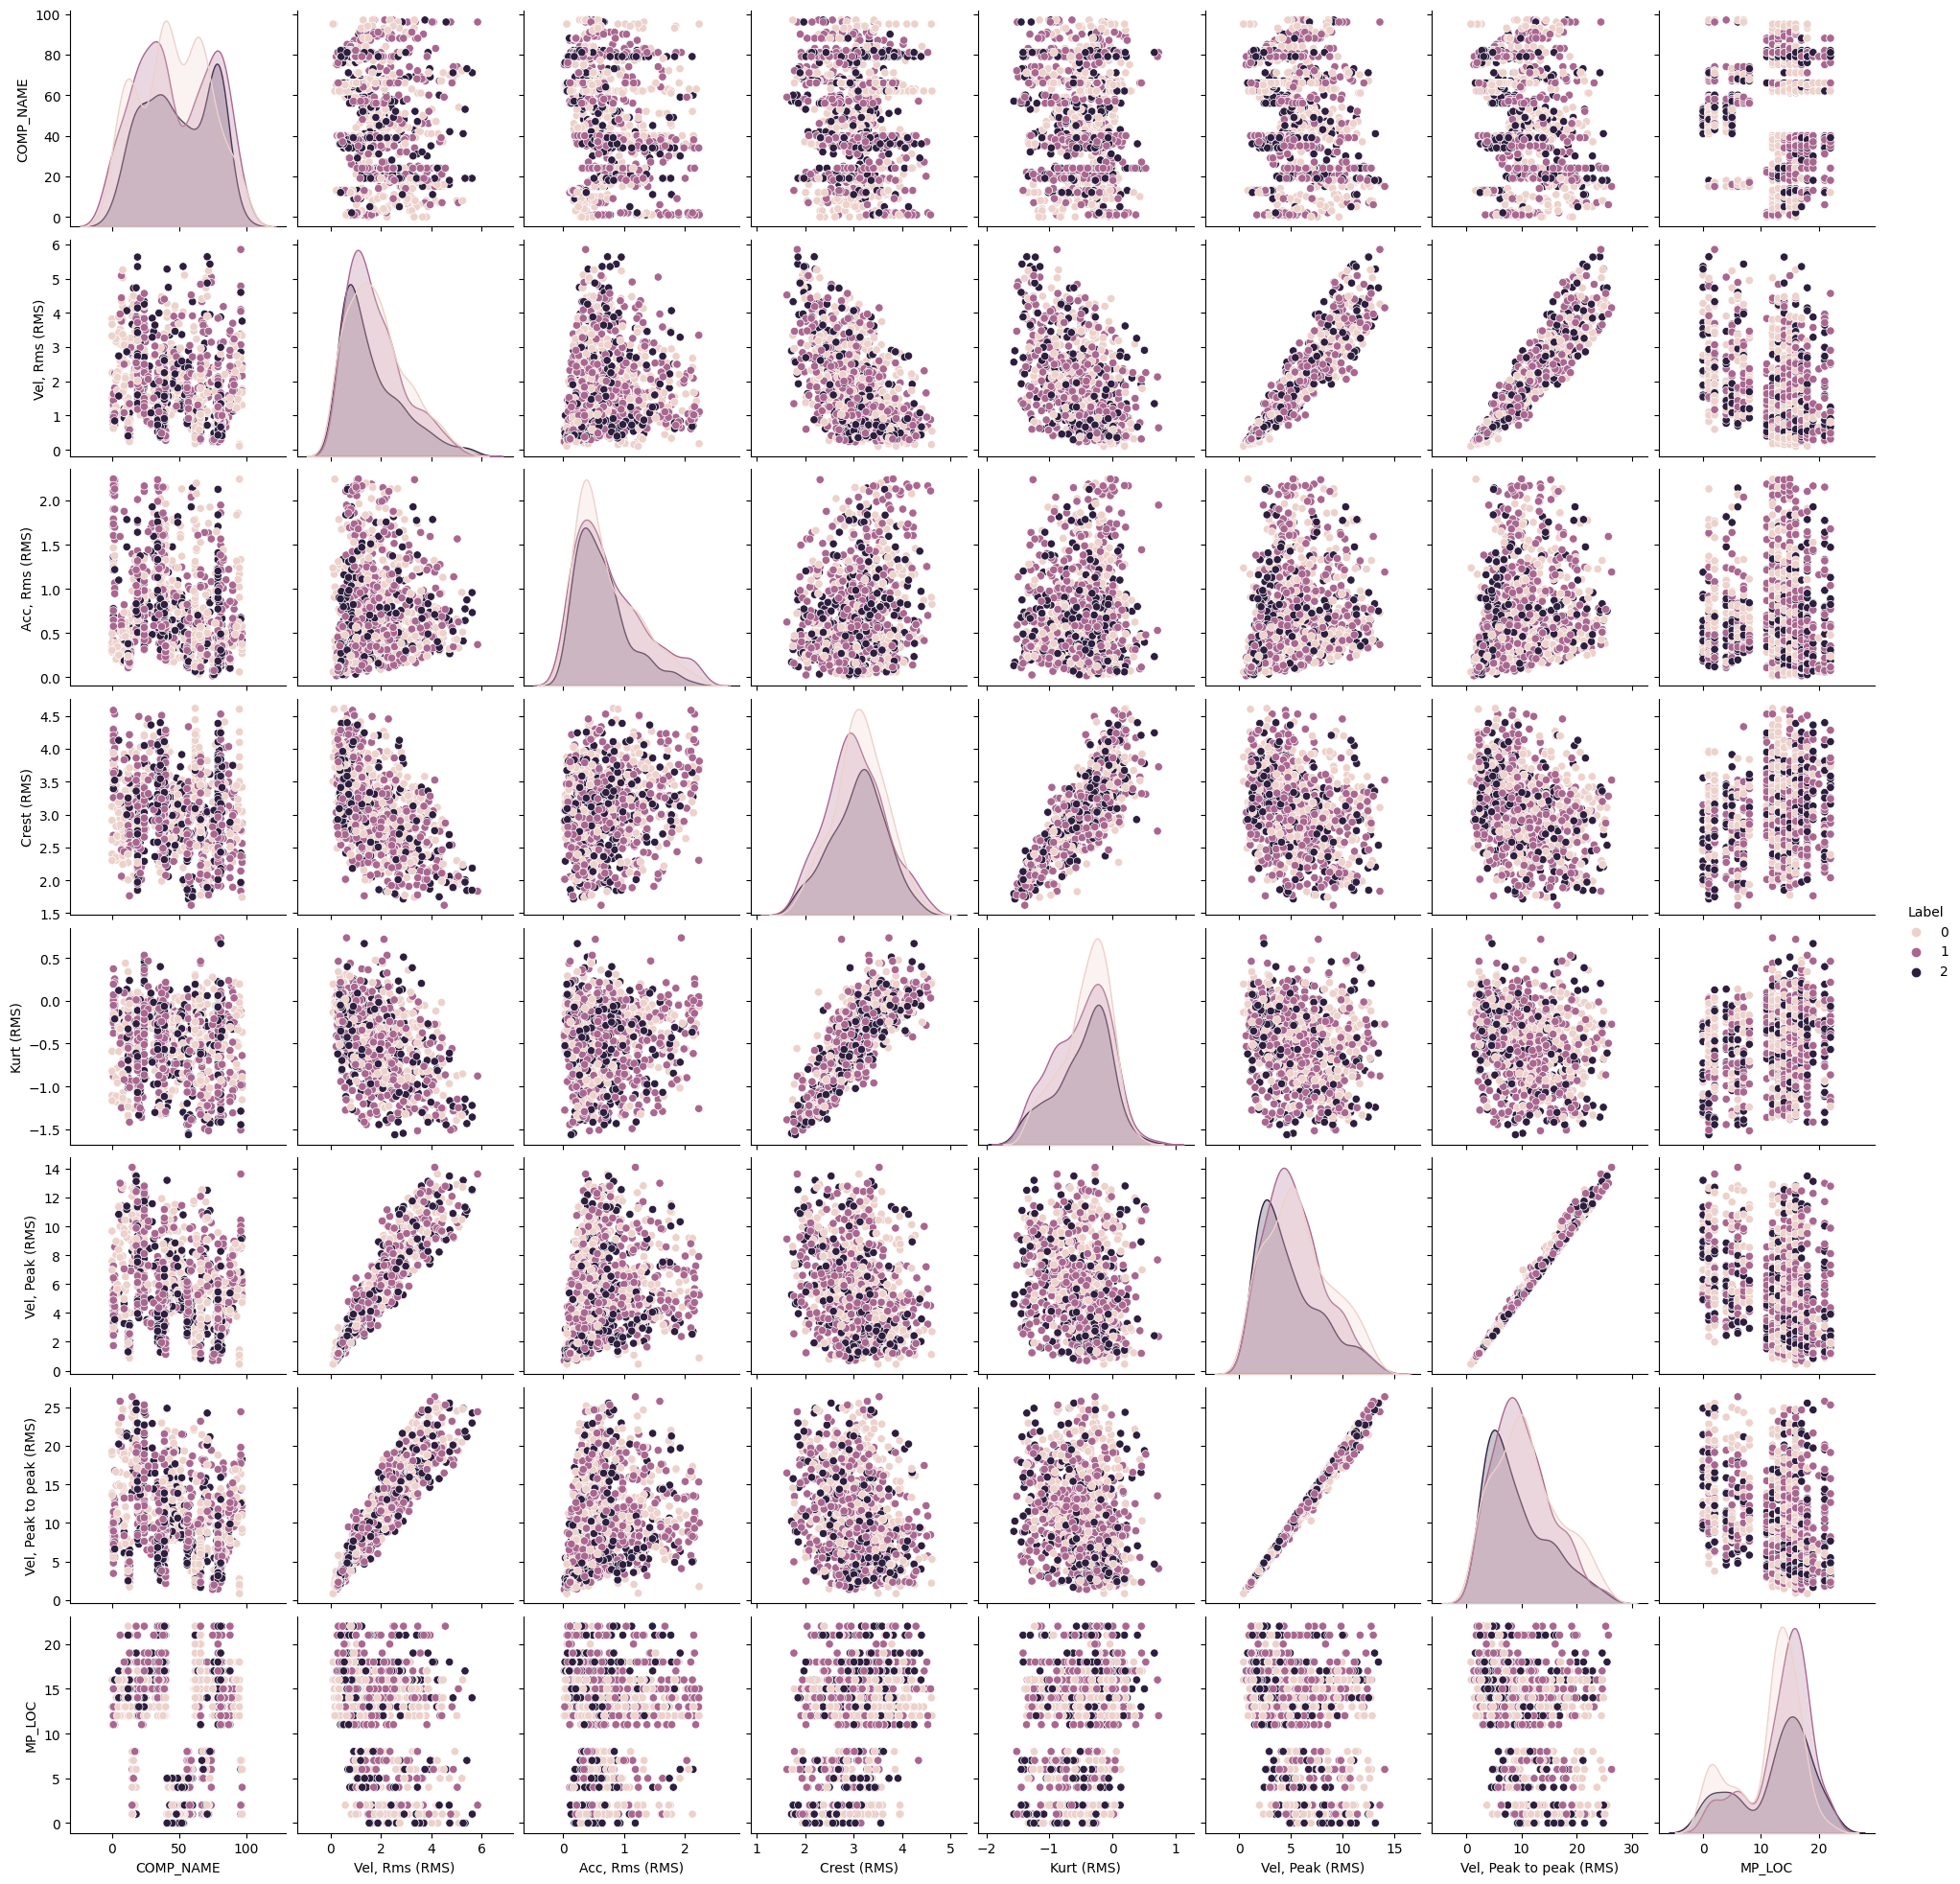

In [188]:
sns.pairplot(df, hue='Label')  # 'target' is the label column
plt.show()

## Normalization

In [189]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_temp = df.drop(columns=['Label'])

scaler = MinMaxScaler()

df[df_temp.columns] = scaler.fit_transform(df_temp)

print(df.head())


   COMP_NAME  Vel, Rms (RMS)  Acc, Rms (RMS)  Crest (RMS)  Kurt (RMS)  \
0   0.463918        0.438392        0.246448     0.384518    0.477613   
1   0.453608        0.263918        0.215782     0.475755    0.511019   
2   0.515464        0.310118        0.091733     0.465569    0.540287   
3   0.505155        0.463282        0.138692     0.326342    0.266289   
4   0.536082        0.257504        0.413246     0.466704    0.521690   

   Vel, Peak (RMS)  Vel, Peak to peak (RMS)  MP_LOC  Label  
0         0.541758                 0.547439     0.0      2  
1         0.350554                 0.372156     0.0      0  
2         0.368562                 0.381504     0.0      0  
3         0.569308                 0.597060     0.0      0  
4         0.326419                 0.348386     0.0      2  


## Exaustive search for feature selection

In [ ]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X = df.drop('Label', axis=1)  # Features
y = df['Label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Split the dataset into train and test sets

# Initialize variables to track the best subset of features
best_score = 0
best_features = None

# Iterate over all possible feature subsets
for r in range(1, len(X.columns) + 1):
    for subset in combinations(X.columns, r):
        # Select subset of features
        X_train_subset = X_train[list(subset)]
        X_test_subset = X_test[list(subset)]

        # Train and evaluate the model using XGBoost
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        model.fit(X_train_subset, y_train)
        score = accuracy_score(y_test, model.predict(X_test_subset))

        # Track the best subset
        if score > best_score:
            best_score = score
            best_features = subset

# Output the results
print("Best features:", best_features)
print("Best accuracy score:", best_score)


c:\Users\Admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\lib\site-packages\

Best features: ('COMP_NAME', 'Vel, Rms (RMS)', 'Acc, Rms (RMS)', 'Kurt (RMS)', 'MP_LOC')
Best accuracy score: 0.6981132075471698


## Keep selected features

In [190]:
df = df[['COMP_NAME', 'Vel, Rms (RMS)', 'Acc, Rms (RMS)', 'Kurt (RMS)', 'MP_LOC', 'Label']]
df

,COMP_NAME,"Vel, Rms (RMS)","Acc, Rms (RMS)",Kurt (RMS),MP_LOC,Label
0,0.463918,0.438392,0.246448,0.477613,0.0,2
1,0.453608,0.263918,0.215782,0.511019,0.0,0
2,0.515464,0.310118,0.091733,0.540287,0.0,0
3,0.505155,0.463282,0.138692,0.266289,0.0,0
4,0.536082,0.257504,0.413246,0.521690,0.0,2
...,...,...,...,...,...,...
1378,0.360825,0.175152,0.745852,0.640331,1.0,1
1379,0.185567,0.423878,0.458350,0.684887,1.0,1
1380,0.381443,0.066883,0.249695,0.574652,1.0,1
1381,0.402062,0.141015,0.362086,0.652003,1.0,2


## Hyperparameter tuning using grid search

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

target_column = 'Label'
X = df.drop(columns=['Crest (RMS)',"Vel, Peak (RMS)", "Vel, Peak to peak (RMS)", target_column])  # Features
y = df[target_column]                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_macro',  # We can use other metrics such as accuracy
    cv=5,                # 5-fold cross-validation
    verbose=1,
    n_jobs=-1            # Use all available CPU cores
)


grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Best Score: 0.6635681003834949

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        52
           1       0.71      0.76      0.73        80
           2       0.62      0.51      0.56        45

    accuracy                           0.71       177
   macro avg       0.70      0.69      0.69       177
weighted avg       0.70      0.71      0.70       177



c:\Users\Admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## PCA

Explained variance ratio of the components:
[0.33906988 0.25055478]


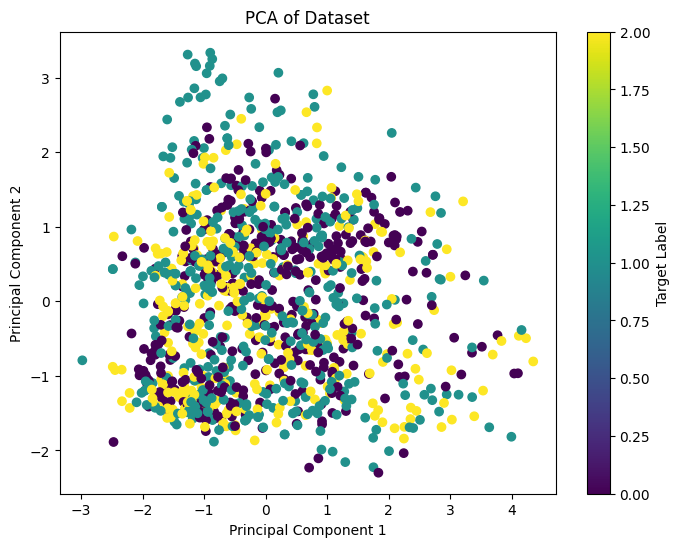

In [191]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df.drop(columns=['Label'])  # Features
y = df['Label']  # Target variable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (In this case we want to reduce to 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])

# add the target column to the PCA DataFrame
pca_df['Label'] = y

# Print the explained variance ratio (this tells us how much variance is explained by each principal component)
print("Explained variance ratio of the components:")
print(pca.explained_variance_ratio_)

# visualize the result
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=y, cmap='viridis')
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Label')
plt.show()


## Final model

In [227]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

# Initialize the XGBoost Classifier
model = XGBClassifier(
    n_estimators=50,      # Number of trees
    max_depth=7,           # Maximum depth of a tree
    learning_rate=0.2,     # Step size shrinkage
    subsample=1.0,         # Subsample ratio of the training instance
    colsample_bytree=0.8,  # Subsample ratio of columns for each tree
    gamma=0.3,
    min_child_weight=1,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       107
           1       0.73      0.78      0.75       104
           2       0.63      0.50      0.56        66

    accuracy                           0.72       277
   macro avg       0.71      0.69      0.70       277
weighted avg       0.72      0.72      0.72       277



# Confusion Matrix

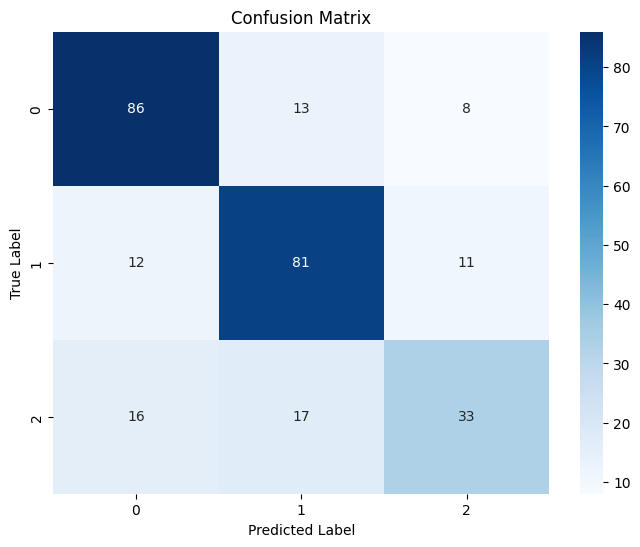

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = [0, 1, 2] 

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and adjust layout
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
